<a href="https://colab.research.google.com/github/juglar-diaz/SentimentAnalysis/blob/master/SentiPred_SocMedia_SKLearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Intro

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
!pip install stop_words

In [0]:
import stop_words

In [0]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

True

In [0]:
import matplotlib.pyplot as plt
import collections

import unicodedata
import re
import numpy as np
import os
import io
import itertools


import random
import pickle
import os
sep = os.sep
import os.path

import pandas as pd
import bisect
import time
import scipy.stats as stats

import datetime

import glob

In [0]:
from nltk.tokenize import word_tokenize
from nltk.book import *

from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn import metrics
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.dummy import DummyClassifier

import warnings; warnings.simplefilter('ignore')
from collections import Counter
from stop_words import get_stop_words


#Download Data

In [0]:
path_data = 'drive/My Drive/Colab Notebooks/RemoteML/Data/'

In [0]:
train = pd.read_json(path_data+"dutch1.json")
train.head()


,author_avatar_url,author_gender,author_location,author_name,author_url,author_username,batch_name,brands,categories,content,emotion,id,language,noise,other,posted_at,relevance_2,sentiment,source,source_domain,source_type,source_url,topics,url,who_curated
0,,,,,http://youtube.com/channel/UClPonqYvdo_XD7m533...,Peter R. de Vries,Seeds_DUTCH_1-1,,,Onderzoek moord Endstra\nKlippen\nHet onderzoe...,,629e6ddbc7d4ef1148b6744307d5025d5c6d12ea,Dutch,,,Sun Apr 23 15:35:14 2017,no,,youtube,www.youtube.com,video,http://www.youtube.com/,,https://www.youtube.com/watch?v=DVUjqOxn2SE,Brechtje
1,,,,,http://youtube.com/channel/UCtVRhmseKQa2DcQnMl...,Pphvideo,Seeds_DUTCH_1-1,,,Een dorsmachine wordt gebruikt voor het dorsen...,,3054dced040ee03753c98ccc77e1638f3db9bbe8,Dutch,,,Wed Sep 21 17:53:52 2016,yes,neutral,youtube,www.youtube.com,video,http://www.youtube.com/,,https://www.youtube.com/watch?v=2FYB25e0_4E,Brechtje
2,,,,,,tuinvrouw agnes,Seeds_DUTCH_1-1,,,"De plant groeit vanuit een flinke bol,eerst on...",,45b7eaddb3f9caaa47795faa7b383536a68e0472,Dutch,,,Mon Sep 19 22:09:01 2016,yes,neutral,tuin den horst,blog.seniorennet.be,blog,http://blog.seniorennet.be/tuindenhorst/,,http://blog.seniorennet.be/tuindenhorst/archie...,Brechtje
3,,,,,,Marja van Spaandonk,Seeds_DUTCH_1-1,,,Sommige planten verdwijnen gewoon\nFoto Taco v...,,4464d4140d217e6f7565f91031242f08a8088ea0,Dutch,,,Sat Jul 23 13:30:25 2016,no,,Leidsch Dagblad,www.leidschdagblad.nl,news,http://www.leidschdagblad.nl,,http://www.leidschdagblad.nl/thema/mens/articl...,Brechtje
4,,,,,,,Seeds_DUTCH_1-1,,,Het is wetenschappelijk bewezen dat een slaapt...,,1a7bbad11ff292f7bb67ea27442285f215439b12,Dutch,,,Tue Jan 17 14:06:04 2017,no,,www.gezondheidsnet.nl,www.gezondheidsnet.nl,news,http://www.gezondheidsnet.nl,,https://www.gezondheidsnet.nl/overgewicht-en-a...,Brechtje


In [0]:
all_files = glob.glob(path_data + "/*.json")

li = []

for filename in all_files:
    df = pd.read_json(filename)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

##Filtering

Lets see what we get in the column sentiment

In [0]:
print(set(df["sentiment"]))

{'', nan, 'not sure', 'positive', 'neutral', 'negative'}


Filter those rows unannotated

In [0]:
df1 = df[~((df["sentiment"]== ""))]

Filter rows nan

In [0]:
df1.dropna(subset=['sentiment'],inplace=True)

In [0]:
print(set(df1["sentiment"]))


{'negative', 'not sure', 'positive', 'neutral'}


I am not sure what the "not sure" classes means and as I do not know dutch, I dont expect to get some inside just by seeing some examples. I will keep this class, but it would be really useful to get some feedback about this class.

##Separating by classes

In [0]:
all_texts_pos = df1[df1["sentiment"] =="positive"]["content"].str.cat(sep=' ')
len(all_texts_pos)

169028

In [0]:
all_texts_neg = df1[df1["sentiment"] =="negative"]["content"].str.cat(sep=' ')
len(all_texts_neg)

34947

In [0]:
all_texts_neu = df1[df1["sentiment"] =="neutral"]["content"].str.cat(sep=' ')
len(all_texts_neu)


512653

In [0]:
all_texts_notsure = df1[df1["sentiment"] =="not sure"]["content"].str.cat(sep=' ')
len(all_texts_notsure)


31968

In [0]:
all_texts_pos_toke = word_tokenize(all_texts_pos)
all_texts_neg_toke = word_tokenize(all_texts_neg)
all_texts_neu_toke = word_tokenize(all_texts_neu)
all_texts_notsure_toke = word_tokenize(all_texts_notsure)

##Some featuring engineering and visualizations

###This section show the most frequent terms for each class

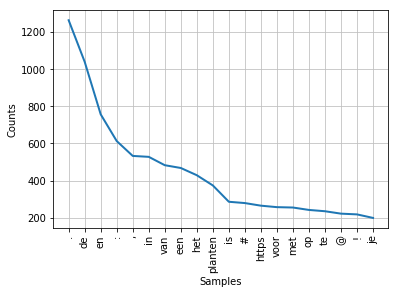

[('.', 1264),
 ('de', 1040),
 ('en', 757),
 (':', 613),
 (',', 533),
 ('in', 528),
 ('van', 483),
 ('een', 468),
 ('het', 429),
 ('planten', 374)]

In [0]:
counter_all_texts_pos = FreqDist(all_texts_pos_toke)
counter_all_texts_pos.plot(20)
counter_all_texts_pos.most_common(10)

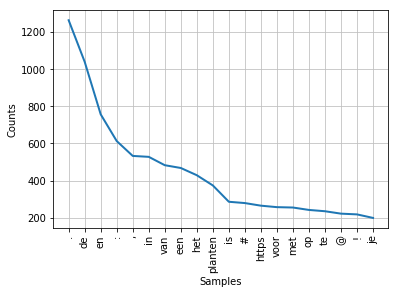

[('.', 1264),
 ('de', 1040),
 ('en', 757),
 (':', 613),
 (',', 533),
 ('in', 528),
 ('van', 483),
 ('een', 468),
 ('het', 429),
 ('planten', 374)]

In [0]:
counter_all_texts_pos = FreqDist(all_texts_pos_toke)
counter_all_texts_pos.plot(20)
counter_all_texts_pos.most_common(10)

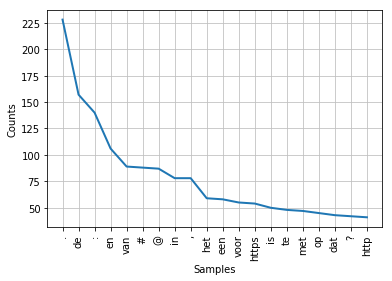

[('.', 228),
 ('de', 157),
 (':', 140),
 ('en', 106),
 ('van', 89),
 ('#', 88),
 ('@', 87),
 ('in', 78),
 (',', 78),
 ('het', 59)]

In [0]:
counter_all_texts_neg = FreqDist(all_texts_neg_toke)
counter_all_texts_neg.plot(20)
counter_all_texts_neg.most_common(10)

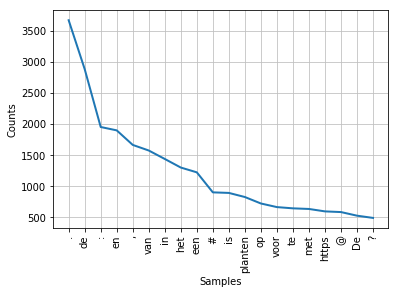

[('.', 3670),
 ('de', 2884),
 (':', 1953),
 ('en', 1899),
 (',', 1665),
 ('van', 1575),
 ('in', 1439),
 ('het', 1301),
 ('een', 1224),
 ('#', 902)]

In [0]:
counter_all_texts_neu = FreqDist(all_texts_neu_toke)
counter_all_texts_neu.plot(20)
counter_all_texts_neu.most_common(10)

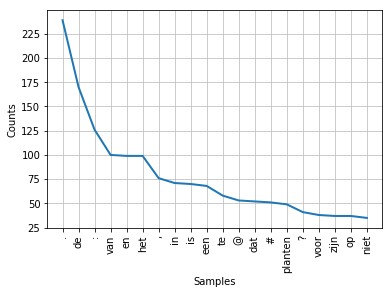

[('.', 239),
 ('de', 170),
 (':', 126),
 ('van', 100),
 ('en', 99),
 ('het', 99),
 (',', 76),
 ('in', 71),
 ('is', 70),
 ('een', 68)]

In [0]:
counter_all_texts_notsure = FreqDist(all_texts_notsure_toke)
counter_all_texts_notsure.plot(20)
counter_all_texts_notsure.most_common(10)

In [0]:
vectorizer= CountVectorizer()
repre = vectorizer.fit_transform(df1["content"])

In [0]:

"""This shows the vectorizer as a disperse matrix, I would not recomend this approach, specially for text data, it is a lot of columns in 
addition to the number of rows and it is not an effective visualition to support decisions about feature engineering with so many rows and columns. 
I would use some feature selection approach (https://scikit-learn.org/stable/modules/feature_selection.html)
 and then plot those features that show more correlation with a particular class.
 I could do some experiment with feature selection if you are interested.
The feature engineering approach that we are taking here is based on a back of words representation, that is effective for tasks like text 
classification by topics, but in the case of sentiment analisis, the sequential nature of text is important and it is lost with a bag of words approach.
"""
print(repre)

  (0, 6835)	1
  (0, 16203)	1
  (0, 1365)	1
  (0, 9933)	2
  (0, 1324)	1
  (0, 8834)	1
  (0, 8916)	1
  (0, 11142)	1
  (0, 1684)	1
  (0, 13509)	1
  (0, 16)	1
  (0, 682)	1
  (0, 5986)	1
  (0, 9963)	1
  (0, 15954)	1
  (0, 14104)	1
  (0, 15330)	1
  (0, 4430)	1
  (0, 2399)	1
  (0, 918)	2
  (0, 10415)	1
  (0, 8922)	1
  (0, 13666)	1
  (0, 3774)	2
  (0, 3870)	1
  :	:
  (3312, 5569)	1
  (3312, 2747)	1
  (3312, 15642)	1
  (3312, 6038)	1
  (3312, 15236)	1
  (3313, 918)	1
  (3313, 3774)	1
  (3313, 6836)	1
  (3313, 3425)	1
  (3313, 10465)	1
  (3313, 7253)	1
  (3313, 14379)	1
  (3313, 3954)	1
  (3313, 13935)	1
  (3313, 14385)	1
  (3313, 11149)	1
  (3313, 40)	2
  (3313, 9902)	1
  (3313, 4579)	2
  (3313, 5549)	1
  (3313, 11229)	1
  (3313, 8829)	1
  (3313, 10632)	1
  (3313, 8592)	1
  (3313, 3358)	1


In [0]:
df1.reset_index(inplace=True)

##Lets see the classes distribution

In [0]:
print("Clases distribution")
df1['sentiment'].value_counts()

Clases distribution


neutral     2228
positive     759
negative     179
not sure     148
Name: sentiment, dtype: int64

There is a clear class unbalance. To deal with this I will do a small experiment oversampling the less represented classes.

Lets make the classes labels numerical with the LabelEncoder from sklearn.

In [0]:
X = list(df1["content"])
y = list(df1["sentiment"])

le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

df1["y"] = y

In [0]:
le.classes_

array(['negative', 'neutral', 'not sure', 'positive'], dtype='<U8')

##First lets split in train-test. 

Any data oversampling, subsampling or manipulation to deal with class unbalance should be done over the training dataset after splitting in train-test. As we are not setting any hyperparameter for the classification models, we are only using training and testing but if we were going to set any hyperparameter we should do train-validation-test, then use validation to set the hyperparameters and report results using the test set.

In [0]:
Xtrain, Xtest, ytrain, ytest = train_test_split(df1["content"], df1["y"], test_size=0.2, stratify=df1["y"])

###Now lets do something about the class unbalance. 

In [0]:
Xtest = pd.DataFrame(Xtest)
ytest = pd.DataFrame(ytest)

In [0]:
ytrain = ytrain.reset_index()
Xtrain = Xtrain.reset_index()

In this cell I will oversample the less represented classes

In [0]:
idx = np.random.choice(ytrain[ytrain["y"] == 0].index, size=465)
Xtrain_oversampled = pd.concat([Xtrain, Xtrain.iloc[idx]])
ytrain_oversampled = pd.concat([ytrain, ytrain.iloc[idx]])

idx = np.random.choice(ytrain[ytrain["y"] == 2].index, size=490)
Xtrain_oversampled = pd.concat([Xtrain_oversampled, Xtrain.iloc[idx]])
ytrain_oversampled = pd.concat([ytrain_oversampled, ytrain.iloc[idx]])
ytrain_oversampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3606 entries, 0 to 2547
Data columns (total 2 columns):
index    3606 non-null int64
y        3606 non-null int64
dtypes: int64(2)
memory usage: 84.5 KB


In [0]:
inv_classes = le.inverse_transform(list(ytrain_oversampled["y"]))
pd.Series(inv_classes).value_counts()

neutral     1782
not sure     609
negative     608
positive     607
dtype: int64

In [0]:
Xtrain = list(Xtrain["content"])
Xtest = list(Xtest["content"])
ytrain =  list(ytrain["y"])
ytest = list(ytest["y"])

In [0]:
Xtrain_oversampled = Xtrain_oversampled["content"]
ytrain_oversampled = ytrain_oversampled["y"]


Since we are going to report several metrics, lets code a function that returns all the metrics.

I report precision, recall, f1 and accuracy. 

It is worst mentioning that accuracy is not a recomended metric when dealing with settings of class unbalance.

In [0]:
# Evaluate the performance of your model
def report_metrics(true_labels, predicted_labels):
    acc = metrics.accuracy_score(true_labels, predicted_labels)
    prec = metrics.precision_score(true_labels, predicted_labels, average='weighted')
    recall =  metrics.recall_score(true_labels, predicted_labels, average='weighted')
    f1 = metrics.f1_score(true_labels, predicted_labels, average='weighted')
    return acc, prec, recall, f1

This function takes as input a model, the data, a vectorizer and then shows the evaluation metrics.

In [0]:
def eval_model(model, Xtrain= Xtrain, ytrain= ytrain, Xtest= Xtest, ytest= ytest, vectorizer= CountVectorizer()):
    vectorizer.fit(Xtrain)
    model.fit(vectorizer.transform(Xtrain), ytrain)
    pred = model.predict(vectorizer.transform(Xtest))
    acc, prec, recall, f1 = report_metrics(ytest, pred)
    
    print("Acc ", acc)
    print("Prec ", prec)
    print("Recall ", recall)
    print("F1 ", f1)

I try several classifiers. I was curious about how a voting classifier would perform so I choose five classifiers representing different hypothesis families and then combined them with a voting classifier. Also, I report a dummy classifier, it is important to prove that the model we are testing is at least better than a very simple baseline.

In [0]:
names = ["Dummy", "Nearest Neighbors",  
         "Decision Tree", "AdaBoost","LogisticRegression","Neural Net","Voting"]

classifiers_voting = [
    KNeighborsClassifier(n_neighbors=7, metric='cosine'),
    DecisionTreeClassifier(max_depth=5),
    AdaBoostClassifier(),
    LogisticRegression(),
    MLPClassifier()]

classifiers = [
    DummyClassifier(),
    KNeighborsClassifier(n_neighbors=7, metric='cosine'),
    DecisionTreeClassifier(max_depth=5),
    AdaBoostClassifier(),
    LogisticRegression(),
    MLPClassifier(),
    VotingClassifier(list(zip(names[1:6],classifiers_voting)))]

I use a st of stop words to reduce the vocabulary. We are using a bag of words approach which do not considers the order of the words, using stop-words can mislead the model. I do not include puntuation marks but those should be excluded too.

In [0]:
stopwords = get_stop_words('dutch')
stopwords = stopwords + get_stop_words('english')
stopwords.append("rt")
stopwords.append("https")
stopwords.append("http")
stopwords.append("co")

In [0]:
vectorizer = CountVectorizer(max_features=5000, max_df = 0.2, min_df = 10, stop_words=stopwords, tokenizer=word_tokenize) 
for i,model in enumerate(classifiers):
    print(names[i])
    eval_model(model,vectorizer=vectorizer)
    print("")


Dummy
Acc  0.49924585218702866
Prec  0.5129468326315613
Recall  0.49924585218702866
F1  0.5056160109280671

Nearest Neighbors
Acc  0.6757164404223228
Prec  0.6041767001377226
Recall  0.6757164404223228
F1  0.6153193584642429

Decision Tree
Acc  0.6681749622926093
Prec  0.5548430880529074
Recall  0.6681749622926093
F1  0.5669855807310235

AdaBoost
Acc  0.6500754147812972
Prec  0.5741339008811011
Recall  0.6500754147812972
F1  0.5970429951359907

LogisticRegression
Acc  0.6636500754147813
Prec  0.6071277648884039
Recall  0.6636500754147813
F1  0.6189226467460509

Neural Net
Acc  0.6470588235294118
Prec  0.6132338231572411
Recall  0.6470588235294118
F1  0.6270585272261633

Voting
Acc  0.6847662141779789
Prec  0.6083042166087149
Recall  0.6847662141779789
F1  0.6166792971261498



All models outperformed the Dummy Classifier and Logistic Regression and the Voting Classifier show the best results. Logistic regression finds simple hypothesis of linearly separable datasets, this hypothesis is simple enough for this dataset.


Lets try tf-idf

In [0]:
vectorizer = TfidfVectorizer(max_features=5000, max_df = 0.2, min_df = 10, stop_words=stopwords, tokenizer=word_tokenize) 
for i,model in enumerate(classifiers):
    print(names[i])
    eval_model(model,vectorizer=vectorizer)
    print("")

Dummy
Acc  0.5354449472096531
Prec  0.5428390979796391
Recall  0.5354449472096531
F1  0.5390779804615657

Nearest Neighbors
Acc  0.669683257918552
Prec  0.5930504547794608
Recall  0.669683257918552
F1  0.6038541358656501

Decision Tree
Acc  0.6726998491704375
Prec  0.5668722129319955
Recall  0.6726998491704375
F1  0.5677245687905422

AdaBoost
Acc  0.6726998491704375
Prec  0.5947174008555083
Recall  0.6726998491704375
F1  0.5861173228831381

LogisticRegression
Acc  0.6923076923076923
Prec  0.6072091490252165
Recall  0.6923076923076923
F1  0.6170390137207633

Neural Net
Acc  0.6319758672699849
Prec  0.6013245482712549
Recall  0.6319758672699849
F1  0.6144801682174527

Voting
Acc  0.6862745098039216
Prec  0.6052260143469661
Recall  0.6862745098039216
F1  0.5992028184951753



We got similar results to using the CountVectorizer

###Lets see what happends with the oversampled data

In [0]:
vectorizer = CountVectorizer(max_features=5000, max_df = 0.2, min_df = 10, stop_words=stopwords, tokenizer=word_tokenize) 
for i,model in enumerate(classifiers):
    print(names[i])
    eval_model(model,Xtrain=Xtrain_oversampled,ytrain=ytrain_oversampled, vectorizer=vectorizer)
    print("")

Dummy
Acc  0.3695324283559578
Prec  0.4635794643180548
Recall  0.3695324283559578
F1  0.40774814237075135

Nearest Neighbors
Acc  0.5806938159879337
Prec  0.6257433220836022
Recall  0.5806938159879337
F1  0.5796451114331066

Decision Tree
Acc  0.6757164404223228
Prec  0.6104024553138988
Recall  0.6757164404223228
F1  0.5720113908601316

AdaBoost
Acc  0.5987933634992458
Prec  0.5225405983324535
Recall  0.5987933634992458
F1  0.5376745734110027

LogisticRegression
Acc  0.6395173453996983
Prec  0.6074142717390297
Recall  0.6395173453996983
F1  0.6178568238229954

Neural Net
Acc  0.6274509803921569
Prec  0.6023869715874909
Recall  0.6274509803921569
F1  0.6133662705022821

Voting
Acc  0.6681749622926093
Prec  0.6156129817894523
Recall  0.6681749622926093
F1  0.5951856668995243



Results got worst with the oversampled data, maybe this should take further studies to get a better inside of why the data oversampled did not improve the results.

### My main conclusion is to get more annotated data and use state of the are models for natural language processing, starting with pretained embedding models and powerful neural networks architectures like LSTM and Transformers. 